Install libraries required

In [1]:
!pip install yt-dlp ultralytics opencv-python matplotlib nest_asyncio streamlink

YOLOv8 Model: Download a pre-trained YOLOv8 object detection model.
Deets here: https://github.com/ultralytics/ultralytics



In [2]:
! yolo task=detect mode=predict model=yolov8n.pt


WARNING ⚠️ 'source' argument is missing. Using default 'source=/usr/local/lib/python3.10/dist-packages/ultralytics/assets'.
Ultralytics YOLOv8.2.52 🚀 Python-3.10.12 torch-2.3.0+cu121 CPU (Intel Xeon 2.20GHz)
YOLOv8n summary (fused): 168 layers, 3151904 parameters, 0 gradients, 8.7 GFLOPs

image 1/2 /usr/local/lib/python3.10/dist-packages/ultralytics/assets/bus.jpg: 640x480 4 persons, 1 bus, 1 stop sign, 659.4ms
image 2/2 /usr/local/lib/python3.10/dist-packages/ultralytics/assets/zidane.jpg: 384x640 2 persons, 1 tie, 568.4ms
Speed: 10.2ms preprocess, 613.9ms inference, 8.3ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/detect/predict4
💡 Learn more at https://docs.ultralytics.com/modes/predict


check feed formats available

In [3]:
!yt-dlp -F https://www.youtube.com/watch?v=6VHnY6ixjLc


[youtube] Extracting URL: https://www.youtube.com/watch?v=6VHnY6ixjLc
[youtube] 6VHnY6ixjLc: Downloading webpage
[youtube] 6VHnY6ixjLc: Downloading ios player API JSON
[youtube] 6VHnY6ixjLc: Downloading m3u8 information
[youtube] 6VHnY6ixjLc: Downloading m3u8 information
[info] Available formats for 6VHnY6ixjLc:
ID  EXT RESOLUTION FPS │   TBR PROTO │ VCODEC        VBR ACODEC     MORE INFO
─────────────────────────────────────────────────────────────────────────────
233 mp4 audio only     │       m3u8  │ audio only        unknown    Default
234 mp4 audio only     │       m3u8  │ audio only        unknown    Default
269 mp4 256x144     15 │  290k m3u8  │ avc1.42C00B  290k video only
91  mp4 256x144     15 │  290k m3u8  │ avc1.42c00b       mp4a.40.5
229 mp4 426x240     30 │  546k m3u8  │ avc1.4D4015  546k video only
92  mp4 426x240     30 │  546k m3u8  │ avc1.4d4015       mp4a.40.5
230 mp4 640x360     30 │ 1210k m3u8  │ avc1.4D401E 1210k video only
93  mp4 640x360     30 │ 1210k m3u8  │ a

In [4]:
!add-apt-repository ppa:jonathonf/ffmpeg-4 -y
!apt update -y
!apt install ffmpeg

Repository: 'deb https://ppa.launchpadcontent.net/jonathonf/ffmpeg-4/ubuntu/ jammy main'
Description:
Backport of FFmpeg 4 and associated libraries. Now includes AOM/AV1 support!

FDK AAC is not compatible with GPL and FFmpeg can't be redistributed with it included. Please don't ask for it to be added to this public PPA.

---

PPA supporters:

BigBlueButton (https://bigbluebutton.org)

---

Donate to FFMPEG: https://ffmpeg.org/donations.html
Donate to Debian: https://www.debian.org/donations
Donate to this PPA: https://ko-fi.com/jonathonf
More info: https://launchpad.net/~jonathonf/+archive/ubuntu/ffmpeg-4
Adding repository.
Found existing deb entry in /etc/apt/sources.list.d/jonathonf-ubuntu-ffmpeg-4-jammy.list
Adding deb entry to /etc/apt/sources.list.d/jonathonf-ubuntu-ffmpeg-4-jammy.list
Found existing deb-src entry in /etc/apt/sources.list.d/jonathonf-ubuntu-ffmpeg-4-jammy.list
Adding disabled deb-src entry to /etc/apt/sources.list.d/jonathonf-ubuntu-ffmpeg-4-jammy.list
Adding key

Added boat detection, to check script was working

analysing too quickly, creates lag


less verbose, stores any images identified containing Orca
extracts videos and processes in parrallel to reduce lag, closer to real time

Processing segment: temp_0.mp4

0: 384x640 5 boats, 179.0ms
Speed: 4.2ms preprocess, 179.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


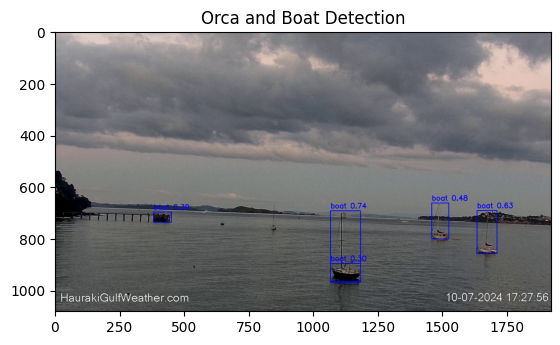


0: 384x640 5 boats, 224.8ms
Speed: 3.9ms preprocess, 224.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


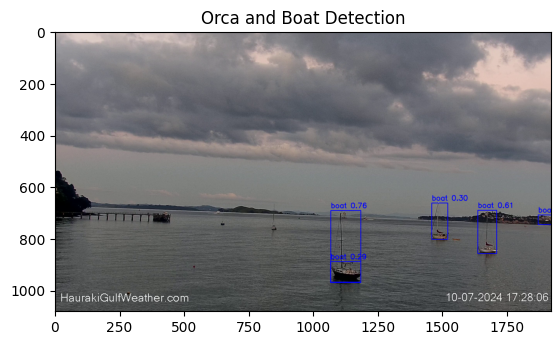


0: 384x640 6 boats, 149.9ms
Speed: 6.1ms preprocess, 149.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


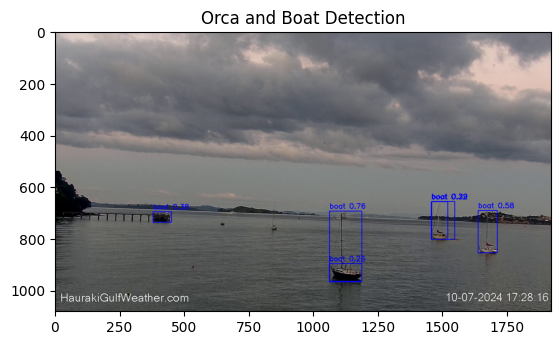

Processing segment: temp_1.mp4

0: 384x640 4 boats, 258.8ms
Speed: 5.6ms preprocess, 258.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


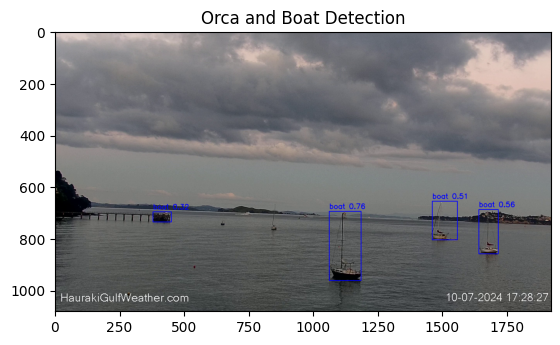


0: 384x640 6 boats, 156.3ms
Speed: 4.7ms preprocess, 156.3ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


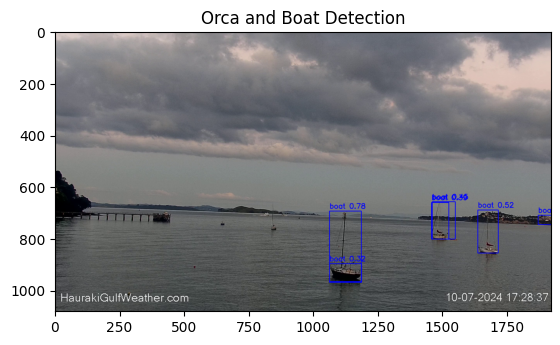


0: 384x640 5 boats, 158.5ms
Speed: 6.5ms preprocess, 158.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


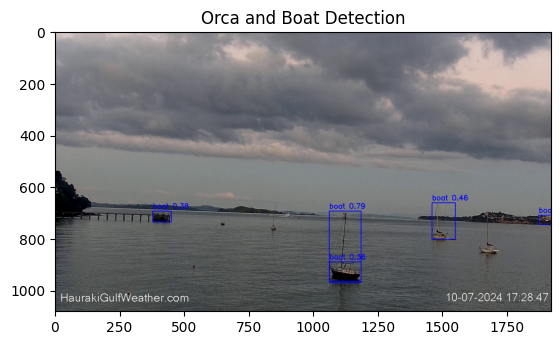

In [ ]:
import cv2
import yt_dlp
import subprocess
import os
import time
import threading
from ultralytics import YOLO
import matplotlib.pyplot as plt
import nest_asyncio

nest_asyncio.apply()

def detect_objects(video_filename, save_directory="orca_detections", model_path="yolov8n.pt"):
    """Detects orcas and boats in a video file and displays every 10th second."""
    model = YOLO(model_path)
    cap = cv2.VideoCapture(video_filename)
    fps = cap.get(cv2.CAP_PROP_FPS)
    interval = 10 * fps
    frame_count = 0

    while cap.isOpened():
        success, frame = cap.read()
        if success:
            if frame_count % interval == 0:
                results = model(frame)
                for result in results:
                    for box in result.boxes:
                        class_id = box.cls[0].item()
                        class_name = model.names[class_id] if class_id < len(model.names) else "unknown"
                        if class_name in ("orca", "boat"):
                            x1, y1, x2, y2 = map(int, box.xyxy[0])
                            color = (0, 255, 0) if class_name == "orca" else (255, 0, 0)
                            cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
                            label = f"{class_name} {box.conf[0]:.2f}"
                            cv2.putText(frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)

                plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
                plt.title("Orca and Boat Detection")
                plt.show()
            frame_count += 1
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
        else:
            break
    cap.release()
    cv2.destroyAllWindows()

def process_segment(segment_filename, save_directory, model_path):
    """Processes a single segment and deletes it afterwards."""
    try:
        print(f"Processing segment: {segment_filename}")
        detect_objects(segment_filename, save_directory, model_path)
    finally:
        os.remove(segment_filename)


def process_live_stream(live_stream_url, save_directory="orca_detections", model_path="yolov8n.pt"):
    """Processes a live stream in chunks using yt_dlp."""
    ydl_opts = {
        'format': 'best',
        'quiet': True,  # Suppress output
    }

    with yt_dlp.YoutubeDL(ydl_opts) as ydl:
        info_dict = ydl.extract_info(live_stream_url, download=False)
        stream_url = info_dict['url']

    segment_counter = 0

    while True:
        segment_filename = f"temp_{segment_counter}.mp4"

        # Record a new segment in a separate thread
        recording_thread = threading.Thread(target=subprocess.run, args=(
            ["ffmpeg", "-y", "-i", stream_url, "-t", "30", "-c", "copy", segment_filename],
        ))
        recording_thread.start()

        # If a previous segment exists, process it in parallel
        if segment_counter > 0:
            prev_segment_filename = f"temp_{segment_counter - 1}.mp4"
            if os.path.exists(prev_segment_filename):
                processing_thread = threading.Thread(target=process_segment, args=(prev_segment_filename, save_directory, model_path))
                processing_thread.start()

        recording_thread.join()  # Wait for the current recording to finish

        segment_counter += 1
        time.sleep(5)  # Adjust delay as needed to ensure smooth overlap


if __name__ == "__main__":
    youtube_url = "https://www.youtube.com/watch?v=6VHnY6ixjLc"
    process_live_stream(youtube_url)
